In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from inox.random import PRNG
from jax import Array
from tqdm import trange
from typing import *

from priors.nn import *
from priors.score import *

from utils import *

In [2]:
rng = PRNG(0)

2024-01-23 16:01:33.084096: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Data

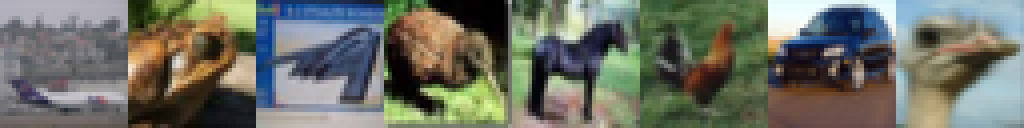

In [3]:
dataset = cifar(split='train')

show(process(dataset[:8]))

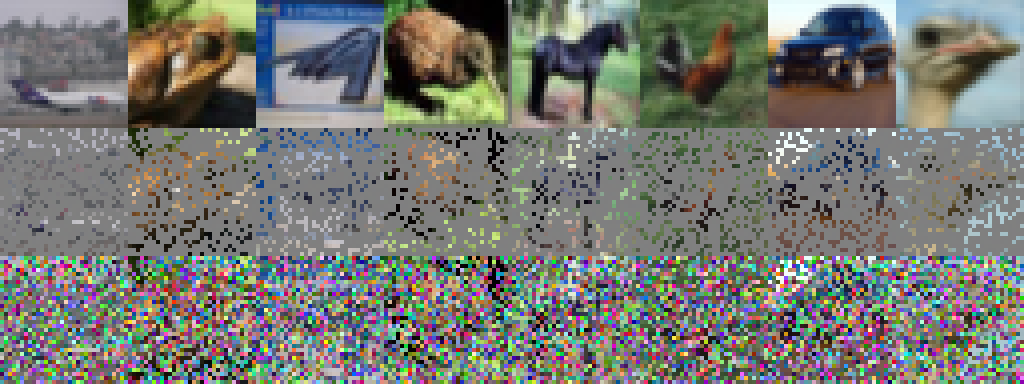

In [4]:
def measure(A, x):
    return flatten(unflatten(A) * unflatten(x))

x = process(dataset[:8])
A = rng.uniform((8, 32 * 32)) < 0.25
y = measure(A, x) + 1e-3 * rng.normal(x.shape)

def sample(model, A, y):
    sampler = Euler(
        PosteriorScoreModel(
            model=model,
            A=inox.Partial(measure, A),
            y=y,
            noise=1e-3,
            gamma=1e-1,
        ),
    )

    z = rng.normal(y.shape)

    return sampler(z, steps=64)

x_bis = sample(StandardScoreModel(), A, y)
show(jnp.stack((x, y, x_bis)))

## Training

In [5]:
def train(previous):
    # Data
    x = process(dataset.shuffle()[:4096])
    A = rng.uniform((len(x), 32 * 32)) < 0.25
    y = measure(A, x) + 1e-3 * rng.normal(x.shape)

    x_bis = jnp.concatenate([
        sample(previous, A[i:i+64], y[i:i+64])
        for i in trange(0, len(x), 64)
    ])

    err = measure(A, x_bis) - y

    print(err.mean(), err.std(), abs(err).max())

    # Train
    model = make_model(key=rng.split(), hid_features=(64, 128, 256), attention={2})
    static, params, others = model.partition(nn.Parameter)

    objective = MeasureLoss()

    scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-6, transition_steps=16384)
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=scheduler),
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def sgd_step(params, others, opt_state, x, A, key):
        def ell(params):
            model = static(params, others)

            z = jax.random.normal(key, x.shape)
            t = jax.random.uniform(key, x.shape[:1])

            return objective(model, x, z, t, inox.Partial(measure, A))

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state

    for step in (bar := trange(16384)):
        i = rng.randint(shape=(64,), minval=0, maxval=len(x))
        loss, params, opt_state = sgd_step(params, others, opt_state, x_bis[i], A[i], rng.split())
        bar.set_postfix(loss=float(loss))

    return static(params, others)

100%|██████████| 64/64 [00:00<00:00, 95.01it/s]


-4.1557996e-08 0.00087521935 0.005419983


100%|██████████| 16384/16384 [19:10<00:00, 14.24it/s, loss=0.0954]


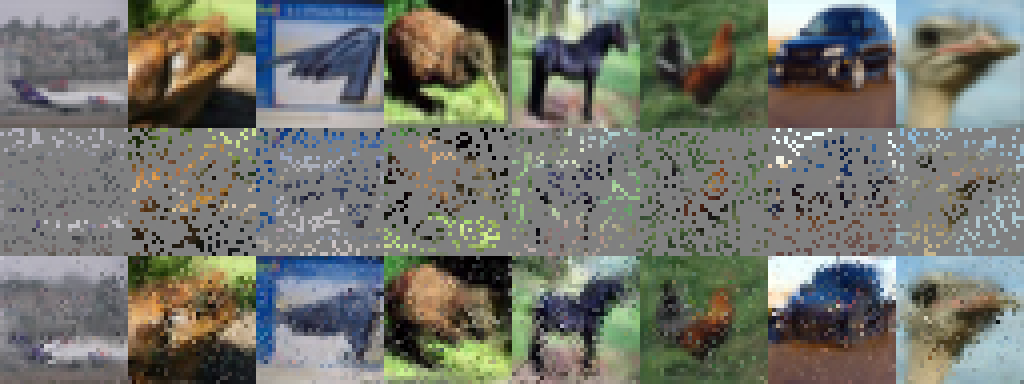

In [6]:
model = train(StandardScoreModel())
x_bis = sample(model, A, y)
show(jnp.stack((x, y, x_bis)))

100%|██████████| 64/64 [05:56<00:00,  5.57s/it]


-2.831277e-07 0.00087882817 0.005124693


100%|██████████| 16384/16384 [18:45<00:00, 14.56it/s, loss=0.089] 


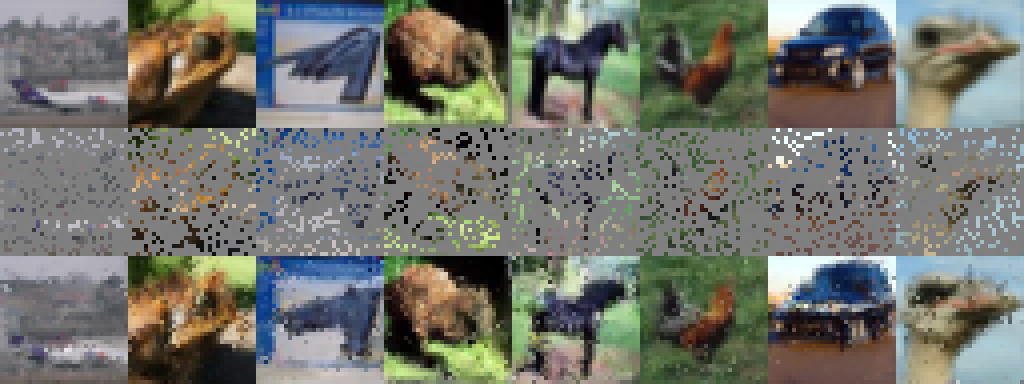

In [7]:
model = train(model)
x_bis = sample(model, A, y)
show(jnp.stack((x, y, x_bis)))

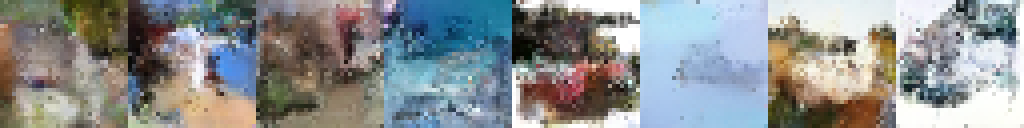

In [8]:
sampler = Euler(model)
x_ter = sampler(rng.normal(x.shape), steps=64)
show(x_ter)